<a href="https://colab.research.google.com/github/RudyMartin/dsai-2024/blob/main/compare_cnn_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Modeling Comparison Template

## Try running your data with this model. Is it better or worse?

Mounted at /content/gdrive
['DSC02677.jpeg', 'Colab Notebooks', 'dscamp_2023', 'dscamp_2022', 'proportions.csv', 'proportions.gsheet', 'activeloop_2023', 'Untitled spreadsheet (1).gsheet', 'Untitled spreadsheet.gsheet', 'YouTube', 'Copy of My Presentation.gslides', 'Introduction .gslides', 'Copy of Introduction .gslides', 'dscamp', 'dscamp_2024_nano', 'ds_camp_2024_trans_hf', 'rps_test', 'rps', 'rps_pics', 'papers']
'rps' directory contents: ['test', 'train', 'models']
Finished Training Model 1
Model 1 saved to /content/gdrive/My Drive/rps/models/model_1.pth
Finished Training Model 2
Model 2 saved to /content/gdrive/My Drive/rps/models/model_2.pth
Accuracy of model_1 on the test images: 38 %
Accuracy of model_2 on the test images: 33 %
Accuracy for model_1 class: rock  is 100.0 %
Accuracy for model_1 class: paper is 0.0 %
Accuracy for model_1 class: scissors is 16.7 %
Accuracy for model_2 class: rock  is 100.0 %
Accuracy for model_2 class: paper is 0.0 %
Accuracy for model_2 class: sci

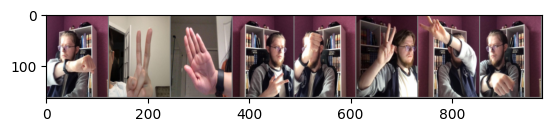

paper scissors scissors scissors paper scissors scissors paper


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# 1. Mount Google Drive to access the dataset
drive.mount('/content/gdrive')

# 2. Verify and list directories
root_dir = '/content/gdrive/My Drive/'
print(os.listdir(root_dir))

rps_dir = os.path.join(root_dir, 'rps')
if os.path.exists(rps_dir):
    print(f"'rps' directory contents: {os.listdir(rps_dir)}")
else:
    raise FileNotFoundError(f"Directory {rps_dir} does not exist.")

train_dir = os.path.join(rps_dir, 'train')
test_dir = os.path.join(rps_dir, 'test')
model_dir = os.path.join(root_dir, 'model')
print(f"rps directory contents: {os.listdir(rps_dir)}")

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomResizedCrop((160, 120), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Adjust based on your dataset statistics
])

# Just normalization for testing
transform_test = transforms.Compose([
    transforms.Resize((160, 120)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Adjust based on your dataset statistics
])

train_path = os.path.join(rps_dir, 'train')
test_path = os.path.join(rps_dir, 'test')

if not os.path.exists(train_path):
    raise FileNotFoundError(f"Training directory {train_path} does not exist.")
if not os.path.exists(test_path):
    raise FileNotFoundError(f"Testing directory {test_path} does not exist.")

trainset = ImageFolder(root=train_path, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

testset = ImageFolder(root=test_path, transform=transform_test)
testloader = DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

classes = ('rock', 'paper', 'scissors')

# Define the network
class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 20 * 15, 256)  # Adjusted input size for smaller images
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 3)
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Instantiate two models
model_1 = ImprovedNet()
model_2 = ImprovedNet()

# Define loss function and optimizers for both models
criterion = nn.CrossEntropyLoss()

# Define different optimizers and schedulers
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=10, gamma=0.1)

optimizer_2 = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)
scheduler_2 = optim.lr_scheduler.CosineAnnealingLR(optimizer_2, T_max=50)

# Training loop for model_1
for epoch in range(5):  # Increase number of epochs to 50 for a real training scenario, using 5 for demo
    running_loss = 0.0
    model_1.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer_1.zero_grad()
        outputs = model_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_1.step()
        running_loss += loss.item()
        if i % 200 == 199:  # Print every 200 mini-batches
            print(f'[Model 1, Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
    scheduler_1.step()

print('Finished Training Model 1')

# Save the trained model_1

model_1_path = os.path.join(model_dir, 'model_1.pth')
torch.save(model_1.state_dict(), model_1_path)
print(f"Model 1 saved to {model_1_path}")

# Training loop for model_2
for epoch in range(5):  # Increase number of epochs to 50 for a real training scenario, using 5 for demo
    running_loss = 0.0
    model_2.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer_2.zero_grad()
        outputs = model_2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_2.step()
        running_loss += loss.item()
        if i % 200 == 199:  # Print every 200 mini-batches
            print(f'[Model 2, Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
    scheduler_2.step()

print('Finished Training Model 2')

# Save the trained model_2
model_2_path = os.path.join(model_dir, 'model_2.pth')
torch.save(model_2.state_dict(), model_2_path)
print(f"Model 2 saved to {model_2_path}")

# Testing loop for model_1
correct = 0
total = 0
model_1.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of model_1 on the test images: {100 * correct // total} %')

# Testing loop for model_2
correct = 0
total = 0
model_2.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of model_2 on the test images: {100 * correct // total} %')

# Accuracy for each class for model_1
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_1(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for model_1 class: {classname:5s} is {accuracy:.1f} %')

# Accuracy for each class for model_2
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model_2(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for model_2 class: {classname:5s} is {accuracy:.1f} %')

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))
